## Imports

In [54]:
import argparse
import os
import time
import sys
import random
import gc
import json
import pickle
from collections import Counter
from multiprocessing import Pool
from pathlib import Path

import mat73
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import nibabel as nib
import scipy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA, PLSRegression as PLS
from IPython.display import Video, HTML
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from pyriemann.estimation import XdawnCovariances, BlockCovariances, Covariances
from pyriemann.tangentspace import TangentSpace

manualSeed = 111
SEED = manualSeed
random.seed(manualSeed)

DATA_PATH = '/data/vladimiroved/realWorldTableTennis'
SUB_ID = '07'
FREQ = 250

## EDA

Your dataset is organized as follows for each subject (e.g., `sub-01`):

- **`anat` Folder**:
  - `sub-01_T1w.nii`: De-identified T1-weighted anatomical MRI scan in NIfTI format.

- **`eeg` Folder**:
  - `sub-01_task-TableTennis_eeg.set`: EEGLAB dataset file containing EEG data.
  - `sub-01_task-TableTennis_eeg.fdt`: EEGLAB binary data file associated with the `.set` file.
  - `sub-01_task-TableTennis_channels.tsv`: Tab-separated file with channel information.
  - `sub-01_task-TableTennis_coordsystem.json`: JSON file describing the coordinate system.
  - `sub-01_task-TableTennis_electrodes.tsv`: Tab-separated file with electrode positions.
  - `sub-01_task-TableTennis_events.tsv`: Tab-separated file with event information.
  - `sub-01_task-TableTennis_events.json`: JSON file describing the events.

In [3]:
eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
anat_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'anat/')

channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
electrodes_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_electrodes.tsv', sep='\t')
events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
participants_df = pd.read_csv(DATA_PATH + '/participants.tsv', sep='\t')

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_coordsystem.json', 'rb') as fd:
    coord_system = json.load(fd)

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.json', 'rb') as fd:
    events = json.load(fd)

with open(DATA_PATH + '/participants.json', 'rb') as fd:
    participants_json = json.load(fd)

### Data View

In [4]:
print(channels_df.shape)
channels_df.sample(5, random_state=SEED)

(299, 3)


,name,type,units
204,N-F8,MISC,NaN
22,FT9,EEG,microV
163,N-CPP3h,MISC,NaN
206,N-AFF6h,MISC,NaN
244,CGY-x,MISC,NaN


In [5]:
print(electrodes_df.shape)
electrodes_df.sample(5, random_state=SEED)

(299, 4)


,name,x,y,z
204,N-F8,NaN,NaN,NaN
22,FT9,32.58,77.83,7.78
163,N-CPP3h,NaN,NaN,NaN
206,N-AFF6h,NaN,NaN,NaN
244,CGY-x,NaN,NaN,NaN


In [6]:
print(events_df.shape)
events_df.sample(5, random_state=SEED)

(3063, 7)


,onset,duration,sample,trial_type,response_time,stim_file,value
2236,3436.684,NaN,859171.0,moving_serve,NaN,NaN,Subject_hit
1279,2135.968,NaN,533992.0,competitive,NaN,NaN,Subject_hit
2840,4092.850,NaN,1023212.5,cooperative,NaN,NaN,M 1
979,1688.136,NaN,422034.0,moving_hit,NaN,NaN,Subject_hit
1347,2231.248,NaN,557812.0,competitive,NaN,NaN,Subject_hit


In [7]:
coord_system, events

({'EEGCoordinateUnits': 'mm',
  'EEGCoordinateSystem': 'Other',
  'EEGCoordinateSystemDescription': 'EEGLAB'},
 {'onset': {'Description': 'Event onset', 'Units': 'second'},
  'trial_type': {'LongName': 'Event categorization',
   'Description': 'Primary categorization of each trial to identify them as instances of the experimental conditions (equivalent to the EEG.event.condlabel field in the data).',
   'Levels': {'competitive': 'Competitive games with a human player',
    'cooperative': 'Cooperative hitting with a human player',
    'moving_hit': 'Ball machine; machine was oscillating; 1 bounce',
    'moving_serve': 'Ball machine; machine was oscillating; 2 bounces',
    'stationary_hit': 'Ball machine; machine was not oscillating; 1 bounce',
    'stationary_serve': 'Ball machine; machine was not oscillating; 2 bounces'}},
  'value': {'Description': 'Type of event (equivalent to the EEG.event.type field in the data).',
   'Levels': {'M 1': 'Sync event recorded with BrainVision system'

In [8]:
raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt


/tmp/ipykernel_1842469/1054951819.py:1: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Oth

Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1842469/1054951819.py:1: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1054951819.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1054951819.py:1: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


**Визуализация обработанных ЭЭГ**

In [9]:
eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()

# Set channel types
channel_types = {}
for ch in raw_eeg.ch_names:
    if ch in eeg_channels:
        channel_types[ch] = 'eeg'
    elif ch in emg_channels:
        channel_types[ch] = 'emg'
    else:
        channel_types[ch] = 'misc'  # Includes IMU and other sensors

raw_eeg.set_channel_types(channel_types)

/tmp/ipykernel_1842469/49138378.py:15: RuntimeWarning: The unit for channel(s) BallMachine_Acc_X(g), BallMachine_Acc_Y(g), BallMachine_Acc_Z(g), CGY-x, CGY-y, CGY-z, CWR-x, CWR-y, CWR-z, Imu_2 :W():, Imu_2 :X():, Imu_2 :Y():, Imu_2 :Z():, Imu_2_ImuGyro :X(D/s):, Imu_2_ImuGyro :Y(D/s):, Imu_2_ImuGyro :Z(D/s):, Imu_2_ImuMag :X(uT):, Imu_2_ImuMag :Y(uT):, Imu_2_ImuMag :Z(uT):, Imu_4 :W():, Imu_4 :X():, Imu_4 :Y():, Imu_4 :Z():, Imu_4_ImuGyro :X(D/s):, Imu_4_ImuGyro :Y(D/s):, Imu_4_ImuGyro :Z(D/s):, Imu_4_ImuMag :X(uT):, Imu_4_ImuMag :Y(uT):, Imu_4_ImuMag :Z(uT):, N-AF3, N-AF4, N-AF7, N-AF8, N-AFF1h, N-AFF2h, N-AFF5h, N-AFF6h, N-AFp1, N-AFp2, N-AFz, N-C1, N-C2, N-C3, N-C4, N-C5, N-C6, N-CCP1h, N-CCP2h, N-CCP3h, N-CCP4h, N-CCP5h, N-CCP6h, N-CP1, N-CP2, N-CP3, N-CP4, N-CP5, N-CP6, N-CPP1h, N-CPP2h, N-CPP3h, N-CPP4h, N-CPP5h, N-CPP6h, N-Cz, N-F1, N-F10, N-F2, N-F3, N-F4, N-F5, N-F6, N-F7, N-F8, N-F9, N-FC1, N-FC2, N-FC3, N-FC4, N-FC5, N-FC6, N-FCC1h, N-FCC2h, N-FCC3h, N-FCC4h, N-FCC5h, N-FCC6

<RawEEGLAB | sub-07_task-TableTennis_eeg.fdt, 299 x 1174503 (4698.0 s), ~2.62 GB, data loaded>

Watch channels names

In [10]:
eeg_channels, misc_channels

(['Fp1',
  'AFp1',
  'AFz',
  'AF3',
  'AF7',
  'AFF5h',
  'AFF1h',
  'F1',
  'F3',
  'F5',
  'F7',
  'F9',
  'FFT9h',
  'FFT7h',
  'FFC5h',
  'FFC3h',
  'FFC1h',
  'FCz',
  'FC1',
  'FC3',
  'FC5',
  'FT7',
  'FT9',
  'FTT9h',
  'FTT7h',
  'FCC5h',
  'FCC3h',
  'FCC1h',
  'C1',
  'C3',
  'C5',
  'T7',
  'TTP7h',
  'CCP5h',
  'CCP3h',
  'CCP1h',
  'CP1',
  'CP3',
  'CP5',
  'TP7',
  'TPP9h',
  'TPP7h',
  'CPP5h',
  'CPP3h',
  'CPP1h',
  'P1',
  'P3',
  'P5',
  'P7',
  'PPO5h',
  'PPO1h',
  'POz',
  'PO3',
  'PO7',
  'PPO9h',
  'POO9h',
  'O1',
  'POO1',
  'OI1h',
  'Iz',
  'Cz',
  'C2',
  'C4',
  'C6',
  'T8',
  'FTT10h',
  'FTT8h',
  'FCC6h',
  'FCC4h',
  'FCC2h',
  'FC2',
  'FC4',
  'FC6',
  'FT8',
  'FT10',
  'FFT10h',
  'FFT8h',
  'FFC6h',
  'FFC4h',
  'FFC2h',
  'Fz',
  'F2',
  'F4',
  'F6',
  'F8',
  'F10',
  'AFF6h',
  'AFF2h',
  'AF4',
  'AF8',
  'FP2',
  'AFp2',
  'Oz',
  'OI2h',
  'POO10h',
  'O2',
  'POO2',
  'PO4',
  'PO8',
  'PPO10h',
  'PPO6h',
  'PPO2h',
  'Pz',
  'P2',


In [11]:
electrodes_df.dropna(inplace=True)

### Извлекаем события и создаём аннотации

Join target data

In [12]:
eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)

events_df['bounces'] = None
events_df['performance'] = None
events_df['device'] = None
events_df['orignum'] = None
events_df.drop(columns=['duration', 'response_time', 'stim_file'], inplace=True, errors='ignore')

empty_array = np.array([])

for i, row in events_df.iterrows():
    mat_event = mat['event'][i]
    
    assert mat_event.type == row['value'], "asynchronous status event_type"
    assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
    assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
    
    if not isinstance(mat_event.bounces, np.ndarray):
        events_df.at[i, 'bounces'] = mat_event.bounces

    if not isinstance(mat_event.performance, np.ndarray):
        events_df.at[i, 'performance'] = mat_event.performance

    if not isinstance(mat_event.code, np.ndarray):
        events_df.at[i, 'device'] = mat_event.code

    if not isinstance(mat_event.orignum, np.ndarray):
        events_df.at[i, 'orignum'] = mat_event.orignum

# mat['event'][200].bounces,\
# mat['event'][200].code,\
# mat['event'][200].condlabel,\
# mat['event'][200].latency,\
# mat['event'][200].orignum,\
# mat['event'][200].performance,\
# mat['event'][200].type

`Subject_hit` in 'moving_hit', 'stationary_hit', 'moving_serve', 'stationary_serve' sessions

In [28]:
events_df

,onset,sample,trial_type,value,bounces,performance,device,orignum
0,-0.002,-0.5,STATUS,boundary,None,None,None,None
1,3.080,770.0,STATUS,M 1,None,None,Master,None
2,8.270,2067.5,STATUS,M 1,None,None,Master,None
3,13.460,3365.0,STATUS,M 1,None,None,Master,None
4,18.650,4662.5,STATUS,M 1,None,None,Master,None
...,...,...,...,...,...,...,...,...
3058,4276.412,1069103.0,cooperative,Subject_receive,1Bounce_Human,1,Cometas_checked,496
3059,4277.064,1069266.0,cooperative,Subject_hit,1Bounce_Human,1,Cometas_checked,497
3060,4277.708,1069427.0,cooperative,Subject_receive,1Bounce_Human,1,Cometas_checked,498
3061,4278.340,1069585.0,cooperative,Subject_hit,1Bounce_Human,2,Cometas_checked,499


In [35]:
from ipywidgets import interact, FloatSlider, Layout


events_subsample_df = events_df\
    .query("value == 'Subject_hit'")\
    .query("trial_type in ('moving_hit', 'stationary_hit', 'moving_serve', 'stationary_serve')")


participant_acc_channels = [
    'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)',
    'Participant_Paddle_Acc_Z(g)'
]

acc_channels = participant_acc_channels
acc_data = raw_eeg.copy().pick_channels(acc_channels)
acc_times = acc_data.times
acc_values = acc_data.get_data()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Defining time shift via XXX

In [36]:
events_df

,onset,sample,trial_type,value,bounces,performance,device,orignum
0,-0.002,-0.5,STATUS,boundary,None,None,None,None
1,3.080,770.0,STATUS,M 1,None,None,Master,None
2,8.270,2067.5,STATUS,M 1,None,None,Master,None
3,13.460,3365.0,STATUS,M 1,None,None,Master,None
4,18.650,4662.5,STATUS,M 1,None,None,Master,None
...,...,...,...,...,...,...,...,...
3058,4276.412,1069103.0,cooperative,Subject_receive,1Bounce_Human,1,Cometas_checked,496
3059,4277.064,1069266.0,cooperative,Subject_hit,1Bounce_Human,1,Cometas_checked,497
3060,4277.708,1069427.0,cooperative,Subject_receive,1Bounce_Human,1,Cometas_checked,498
3061,4278.340,1069585.0,cooperative,Subject_hit,1Bounce_Human,2,Cometas_checked,499


In [45]:
events_subsample_df

,onset,sample,trial_type,value,bounces,performance,device,orignum
581,1069.804,267451.0,stationary_serve,Subject_hit,2Bounce_BM,2,Cometas_checked,1
582,1071.884,267971.0,stationary_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,2
584,1073.904,268476.0,stationary_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,3
585,1075.524,268881.0,stationary_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,4
586,1077.976,269494.0,stationary_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,5
...,...,...,...,...,...,...,...,...
2467,3811.884,952971.0,moving_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,59
2469,3815.484,953871.0,moving_serve,Subject_hit,2Bounce_BM,2,Cometas_checked,60
2470,3817.436,954359.0,moving_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,61
2472,3821.392,955348.0,moving_serve,Subject_hit,2Bounce_BM,1,Cometas_checked,62


In [40]:
acc_ttl_data = np.sqrt(np.sum(np.square(acc_values), axis=0))

labels_data = np.zeros_like(acc_ttl_data)
hit_indices = (events_subsample_df['sample'] + 0.5).astype(int)
labels_data[hit_indices.values] = 1

In [41]:
def calculate_corr(i):
    return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]


def calculate_cov(i):
    return np.dot(acc_ttl_data[i:], labels_data[:labels_data.size-i])


with Pool() as pool:
    similarity_arr = list(tqdm(pool.imap(calculate_corr, range(acc_ttl_data.size // 10)), total=acc_ttl_data.size // 10))

  0%|          | 0/117450 [00:00<?, ?it/s]

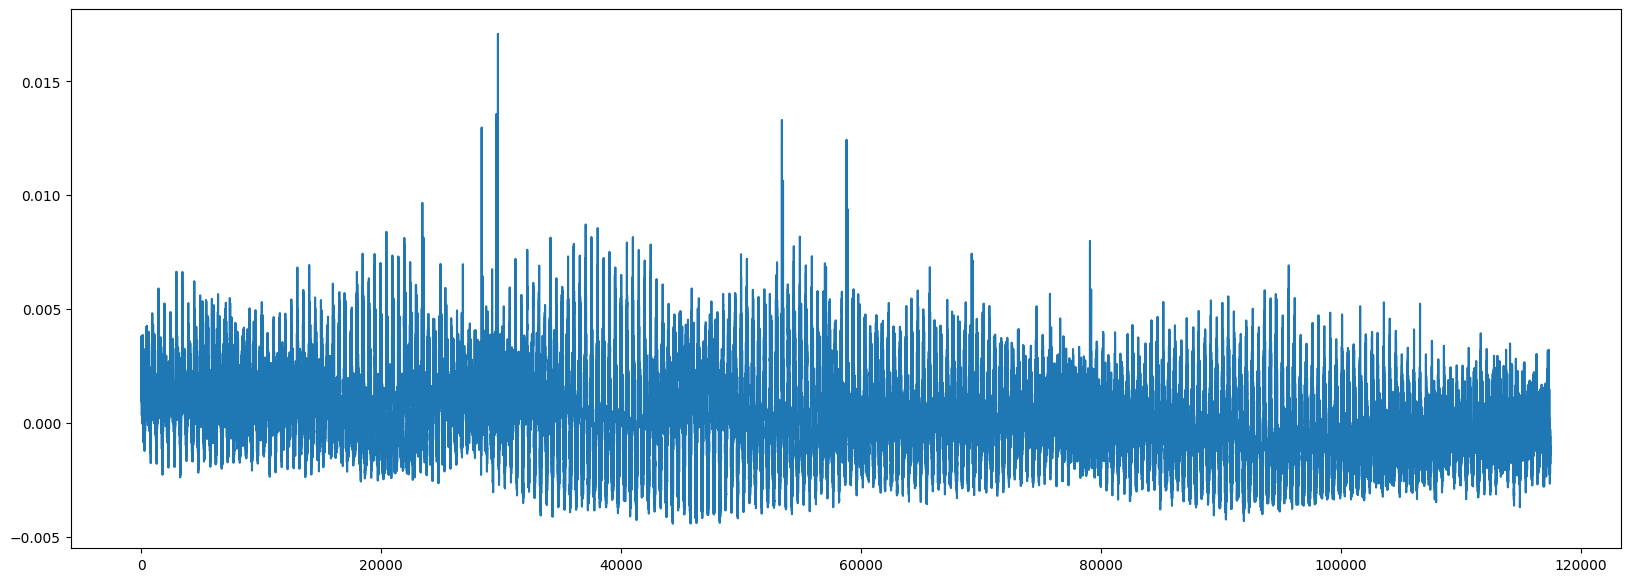

In [43]:
plt.figure(figsize=(20, 7))
plt.plot(similarity_arr)
plt.show()

In [51]:
np.argsort(similarity_arr)[::-1]

array([29737, 29738, 29604, ..., 46281, 45790, 44316])

It seems that there's no shift

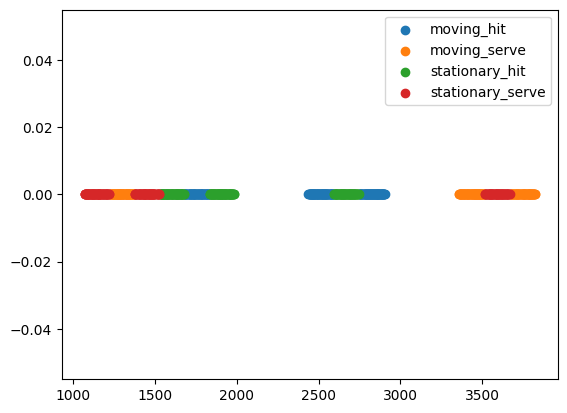

In [55]:
moving_hit_values = events_subsample_df.query("trial_type == 'moving_hit'").onset
moving_serve_values = events_subsample_df.query("trial_type == 'moving_serve'").onset
stationary_hit_values = events_subsample_df.query("trial_type == 'stationary_hit'").onset
stationary_serve_values = events_subsample_df.query("trial_type == 'stationary_serve'").onset

plt.scatter(moving_hit_values, np.zeros_like(moving_hit_values), alpha=1, label='moving_hit')
plt.scatter(moving_serve_values, np.zeros_like(moving_serve_values), alpha=1, label='moving_serve')
plt.scatter(stationary_hit_values, np.zeros_like(stationary_hit_values), alpha=1, label='stationary_hit')
plt.scatter(stationary_serve_values, np.zeros_like(stationary_serve_values), alpha=1, label='stationary_serve')

plt.legend()
plt.show()

In [73]:
def find_continuous_sessions(onset_times, gap_threshold):
    # 1) Sort all onsets
    onsets = np.sort(np.asarray(onset_times))
    if len(onsets) == 0:
        return []

    # 2) Compute gaps between consecutive onsets
    diffs = np.diff(onsets)  # array of length (n_events-1)

    # 3) Wherever diff > gap_threshold, mark a "break"
    #    We record the indices where a new session begins (i+1)
    break_indices = np.where(diffs > gap_threshold)[0]

    # 4) Build start/end indices for each block
    #    - The very first session starts at index 0
    #    - Each break at diffs[i] means onsets[i] ends a session, onsets[i+1] begins the next.
    session_starts = np.concatenate([[0], break_indices + 1])
    session_ends   = np.concatenate([break_indices, [len(onsets) - 1]])

    # 5) Turn those into (start_time, end_time) pairs
    sessions = []
    for s_idx, e_idx in zip(session_starts, session_ends):
        start_t = float(onsets[s_idx])
        end_t   = float(onsets[e_idx])
        sessions.append((start_t, end_t))

    return sessions


def get_sessions_range(events_df: pd.DataFrame, sessions_delta: int = 60):
    return np.array(find_continuous_sessions(events_df.onset.values, sessions_delta)).reshape(-1, 2)

sessions_arr = get_sessions_range(events_subsample_df, 60)
sessions_arr

array([[1069.804, 1982.572],
       [2437.488, 2903.804],
       [3357.012, 3825.608]])

In [86]:
MAX_SHIFT = acc_ttl_data.size - events_df['sample'].astype(int).max()
peaks_arr = []
EPS = 0.001

for start, end in sessions_arr:
    start_delta = int(start * FREQ)
    acc_slice = acc_ttl_data[start_delta:]
    
    labels_data = np.zeros_like(acc_slice)
    session_subdf = events_subsample_df.query(f"{start - EPS} <= onset <= {end + EPS}")
    hit_indices = (session_subdf['sample'] + 0.5).astype(int) - start_delta
    labels_data[hit_indices.values] = 1

    def calculate_corr(i):
        return np.corrcoef(acc_slice[i:], labels_data[:labels_data.size-i])[0, 1]
    
    with Pool() as pool:
        max_shift = min(MAX_SHIFT, acc_slice.size - 1)
        similarity_arr = list(tqdm(pool.imap(calculate_corr, range(max_shift)), total=max_shift))

    peak = start_delta + np.argmax(similarity_arr)
    peaks_arr.append(peak)

  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

### Collect shifts

In [63]:
def find_k_peaks(arr: np.ndarray, k: int = 4, delta_min: int = 1000):
    peaks = []

    for elem in arr:
        peaks_len = len(peaks)

        if peaks_len >= k:
            break
        elif peaks_len == 0:
            peaks.append(elem)
            continue

        to_add = True
        for peak in peaks:
            if abs(peak - elem) < delta_min:
                to_add = False
                break

        if to_add:
            peaks.append(elem)

    return sorted(peaks)


find_k_peaks(np.argsort(similarity_arr)[::-1])

[28378, 29737, 53403, 58792]

#### Variant 3

1. Calculate shift array for researcher, utilizing accelerometer data
2. Find k sessions timesteps, where k $\in \{ 3; 4 \}$
3. Find k peaks in shift array
5. Map session to peak in ascending order

In [118]:
!mkdir -p ball-machine/shifts_v3
SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

    events_subdf = events_df\
        .query("value == 'Subject_hit'")\
        .query("trial_type in ('moving_hit', 'stationary_hit', 'moving_serve', 'stationary_serve')")
    
    acc_channels = [
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    ]
    acc_data = raw_eeg.pick_channels(acc_channels)
    acc_values = acc_data.get_data()
    acc_ttl_data = np.sqrt(np.sum(np.square(acc_values), axis=0))
    
    labels_data = np.zeros_like(acc_ttl_data)
    hit_indices = (events_subdf['sample'] + 0.5).astype(int)
    labels_data[hit_indices.values] = 1

    max_shift = acc_ttl_data.size - events_df['sample'].astype(int).max()

    def calculate_corr(i):
        return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]
    
    with Pool() as pool:
        similarity_arr = list(tqdm(pool.imap(calculate_corr, range(max_shift)), total=max_shift))

    sessions_arr = get_sessions_range(events_subdf)
    peaks_arr = find_k_peaks(np.argsort(similarity_arr)[::-1], k=len(sessions_arr))
    
    np.savez_compressed(
        f'ball-machine/shifts_v3/{SUB_ID}.npz',
        sessions=sessions_arr,
        peaks=peaks_arr,
    )
    
    gc.collect()

  0%|          | 0/25 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/88709 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-02/eeg/sub-02_task-TableTennis_eeg.fdt
Reading 0 ... 1364632  =      0.000 ...  5458.528 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44371 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-03/eeg/sub-03_task-TableTennis_eeg.fdt
Reading 0 ... 1099795  =      0.000 ...  4399.180 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100901 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-04/eeg/sub-04_task-TableTennis_eeg.fdt
Reading 0 ... 1057035  =      0.000 ...  4228.140 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/385681 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-05/eeg/sub-05_task-TableTennis_eeg.fdt
Reading 0 ... 1038925  =      0.000 ...  4155.700 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44860 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58989 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/104588 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/96587 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/79593 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


  0%|          | 0/69785 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51061 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/64968 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-13/eeg/sub-13_task-TableTennis_eeg.fdt
Reading 0 ... 1120665  =      0.000 ...  4482.660 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58408 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-14/eeg/sub-14_task-TableTennis_eeg.fdt
Reading 0 ... 1129763  =      0.000 ...  4519.052 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/73918 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56375 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/83889 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/61956 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-18/eeg/sub-18_task-TableTennis_eeg.fdt
Reading 0 ... 1155502  =      0.000 ...  4622.008 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100154 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56880 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69020 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/63256 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51696 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-23/eeg/sub-23_task-TableTennis_eeg.fdt
Reading 0 ... 1053820  =      0.000 ...  4215.280 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8 :Z():', 'Im

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69728 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-24/eeg/sub-24_task-TableTennis_eeg.fdt
Reading 0 ... 1146790  =      0.000 ...  4587.160 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/342 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-25/eeg/sub-25_task-TableTennis_eeg.fdt
Reading 0 ... 877573  =      0.000 ...  3510.292 secs...


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/3764265414.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/36255 [00:00<?, ?it/s]

#### Variant 4


1. Find k sessions timesteps
2. Calculate shift array for each session with researcher (k shift arrays in total)
3. Find 1 peak for each shift array
4. Map session to peak in ascending order

In [94]:
!mkdir -p ball-machine/shifts_v4
SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]
EPS = 0.001
FREQ = 250

for SUB_ID in tqdm(SUB_IDS):    
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

    events_subdf = events_df\
        .query("value == 'Subject_hit'")\
        .query("trial_type in ('moving_hit', 'stationary_hit', 'moving_serve', 'stationary_serve')")
    
    acc_channels = [
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    ]
    acc_data = raw_eeg.pick_channels(acc_channels)
    acc_values = acc_data.get_data()
    acc_ttl_data = np.sqrt(np.sum(np.square(acc_values), axis=0))

    sessions_arr = get_sessions_range(events_subdf)
    peaks_arr = []
    max_shift = acc_ttl_data.size - events_df['sample'].astype(int).max()
    
    for start, end in sessions_arr:
        start_delta = int(start * FREQ)
        acc_slice = acc_ttl_data[start_delta:]
        
        labels_data = np.zeros_like(acc_slice)
        session_subdf = events_subdf.query(f"{start - EPS} <= onset <= {end + EPS}")
        hit_indices = (session_subdf['sample'] + 0.5).astype(int) - start_delta
        labels_data[hit_indices.values] = 1
    
        def calculate_corr(i):
            return np.corrcoef(acc_slice[i:], labels_data[:labels_data.size-i])[0, 1]
        
        with Pool() as pool:
            max_shift_session = min(max_shift, acc_slice.size - 1)
            similarity_arr = list(tqdm(pool.imap(calculate_corr, range(max_shift_session)), total=max_shift_session))
    
        peak = np.argmax(similarity_arr)
        peaks_arr.append(peak)
    
    np.savez_compressed(
        f'ball-machine/shifts_v4/{SUB_ID}.npz',
        sessions=sessions_arr,
        peaks=peaks_arr,
    )
    
    gc.collect()

  0%|          | 0/25 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/88709 [00:00<?, ?it/s]

  0%|          | 0/88709 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-02/eeg/sub-02_task-TableTennis_eeg.fdt
Reading 0 ... 1364632  =      0.000 ...  5458.528 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44371 [00:00<?, ?it/s]

  0%|          | 0/44371 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-03/eeg/sub-03_task-TableTennis_eeg.fdt
Reading 0 ... 1099795  =      0.000 ...  4399.180 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100901 [00:00<?, ?it/s]

  0%|          | 0/100901 [00:00<?, ?it/s]

  0%|          | 0/100901 [00:00<?, ?it/s]

  0%|          | 0/100901 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-04/eeg/sub-04_task-TableTennis_eeg.fdt
Reading 0 ... 1057035  =      0.000 ...  4228.140 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/385681 [00:00<?, ?it/s]

  0%|          | 0/385681 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-05/eeg/sub-05_task-TableTennis_eeg.fdt
Reading 0 ... 1038925  =      0.000 ...  4155.700 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44860 [00:00<?, ?it/s]

  0%|          | 0/44860 [00:00<?, ?it/s]

  0%|          | 0/44860 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58989 [00:00<?, ?it/s]

  0%|          | 0/58989 [00:00<?, ?it/s]

  0%|          | 0/58989 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/96587 [00:00<?, ?it/s]

  0%|          | 0/96587 [00:00<?, ?it/s]

  0%|          | 0/96587 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/79593 [00:00<?, ?it/s]

  0%|          | 0/79593 [00:00<?, ?it/s]

  0%|          | 0/79593 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69785 [00:00<?, ?it/s]

  0%|          | 0/69785 [00:00<?, ?it/s]

  0%|          | 0/69785 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51061 [00:00<?, ?it/s]

  0%|          | 0/51061 [00:00<?, ?it/s]

  0%|          | 0/51061 [00:00<?, ?it/s]

  0%|          | 0/51061 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/64968 [00:00<?, ?it/s]

  0%|          | 0/64968 [00:00<?, ?it/s]

  0%|          | 0/64968 [00:00<?, ?it/s]

  0%|          | 0/64968 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-13/eeg/sub-13_task-TableTennis_eeg.fdt
Reading 0 ... 1120665  =      0.000 ...  4482.660 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58408 [00:00<?, ?it/s]

  0%|          | 0/58408 [00:00<?, ?it/s]

  0%|          | 0/58408 [00:00<?, ?it/s]

  0%|          | 0/58408 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-14/eeg/sub-14_task-TableTennis_eeg.fdt
Reading 0 ... 1129763  =      0.000 ...  4519.052 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/73918 [00:00<?, ?it/s]

  0%|          | 0/73918 [00:00<?, ?it/s]

  0%|          | 0/73918 [00:00<?, ?it/s]

  0%|          | 0/73918 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56375 [00:00<?, ?it/s]

  0%|          | 0/56375 [00:00<?, ?it/s]

  0%|          | 0/56375 [00:00<?, ?it/s]

  0%|          | 0/56375 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/83889 [00:00<?, ?it/s]

  0%|          | 0/83889 [00:00<?, ?it/s]

  0%|          | 0/83889 [00:00<?, ?it/s]

  0%|          | 0/83889 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/61956 [00:00<?, ?it/s]

  0%|          | 0/61956 [00:00<?, ?it/s]

  0%|          | 0/61956 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-18/eeg/sub-18_task-TableTennis_eeg.fdt
Reading 0 ... 1155502  =      0.000 ...  4622.008 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100154 [00:00<?, ?it/s]

  0%|          | 0/100154 [00:00<?, ?it/s]

  0%|          | 0/100154 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69020 [00:00<?, ?it/s]

  0%|          | 0/69020 [00:00<?, ?it/s]

  0%|          | 0/69020 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/63256 [00:00<?, ?it/s]

  0%|          | 0/63256 [00:00<?, ?it/s]

  0%|          | 0/63256 [00:00<?, ?it/s]

  0%|          | 0/63256 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51696 [00:00<?, ?it/s]

  0%|          | 0/51696 [00:00<?, ?it/s]

  0%|          | 0/51696 [00:00<?, ?it/s]

  0%|          | 0/51696 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-23/eeg/sub-23_task-TableTennis_eeg.fdt
Reading 0 ... 1053820  =      0.000 ...  4215.280 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8 :Z():', 'Im

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69728 [00:00<?, ?it/s]

  0%|          | 0/69728 [00:00<?, ?it/s]

  0%|          | 0/69728 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-24/eeg/sub-24_task-TableTennis_eeg.fdt
Reading 0 ... 1146790  =      0.000 ...  4587.160 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-25/eeg/sub-25_task-TableTennis_eeg.fdt
Reading 0 ... 877573  =      0.000 ...  3510.292 secs...


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1842469/1458919944.py:12: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/36255 [00:00<?, ?it/s]

  0%|          | 0/36255 [00:00<?, ?it/s]

  0%|          | 0/36255 [00:00<?, ?it/s]

### Compare variants 3 and 4

In [119]:
sub_ids = ['0' * (n < 10) + str(n) for n in range(1, 26)]
shifts_v3 = [np.load(f'ball-machine/shifts_v3/{sub_id}.npz') for sub_id in sub_ids]
shifts_v4 = [np.load(f'ball-machine/shifts_v4/{sub_id}.npz') for sub_id in sub_ids]

for i in range(len(sub_ids)):
    shift_3 = shifts_v3[i]['peaks'].reshape(-1)
    shift_4 = shifts_v4[i]['peaks'].reshape(-1)

    print(i+1)
    print(shift_3)
    print(shift_4)

1
[79869 80965]
[43722 80965]
2
[17767 20584]
[ 2128 17767]
3
[   98 63898 66301 90523]
[   98 21456 66301 90523]
4
[  560 10355]
[  560 10355]
5
[22198 23960 28993]
[ 5512 23960 28993]
6
[19880 20932 49487]
[20932 49487 57944]
7
[28378 29737 53403]
[29737 58792 69320]
8
[ 2004 10005 39967]
[ 2004 39967 67746]
9
[10744 12195 27467]
[19566 44549 72994]
10
[18704 47652 50158]
[ 3429 18704 50158]
11
[19916 21448 28380 49884]
[ 1543 21448 28380 49884]
12
[ 1858  3093 15809 61945]
[ 1858 15809 26245 61945]
13
[ 7584  9084 10680 39205]
[ 7584 22109 39205 57815]
14
[ 1360  4423  6751 73702]
[ 4423 37360 54202 73703]
15
[ 5883 19747 51302 55004]
[ 5883 19746 32402 55004]
16
[ 1529 36759 54657 82486]
[ 1529 36759 54657 82486]
17
[17989 34513 48499]
[17990 34513 50572]
18
[50969 85535 90129]
[11896 50969 90129]
19
[ 6191 13701 16919 46999]
[ 6191 13701 30680 46999]
20
[18568 21622 39415]
[18568 36409 51119]
21
[11823 14795 57506 61478]
[ 1888 11823 32430 57506]
22
[ 6448 15408 29537 48736]
[ 644

Выберем 4 вариант

In [120]:
# In tennis forehand stroke studies using IMUs, acceleration peaks typically occur about 8–12 ms after actual ball contact.
# 12 ms = 12 / 1000 sec = 3 / 250 sec = 3 steps
EVENT_TO_PEAK_SHIFT = 3

!mkdir -p ball-machine/shifts_final

sub_ids = ['0' * (n < 10) + str(n) for n in range(1, 26)]
shifts_v3 = [np.load(f'ball-machine/shifts_v3/{sub_id}.npz') for sub_id in sub_ids]
shifts_v4 = [np.load(f'ball-machine/shifts_v4/{sub_id}.npz') for sub_id in sub_ids]

for i, sub_id in enumerate(sub_ids):
    shift = shifts_v4[i]

    np.savez_compressed(
        f'ball-machine/shifts_final/{sub_id}.npz',
        sessions=shift['sessions'],
        peaks=shift['peaks'] - EVENT_TO_PEAK_SHIFT,
    )

## Final flow

In [121]:
!mkdir -p ball-machine/data

In [ ]:
PARTICIPANT_CHANNELS = [
    'Fp1', 'AFp1', 'AFz', 'AF3', 'AF7', 'AFF5h', 'AFF1h', 'F1', 'F3',
    'F5', 'F7', 'F9', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h',
    'FCz', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'FTT9h', 'FTT7h',
    'FCC5h', 'FCC3h', 'FCC1h', 'C1', 'C3', 'C5', 'T7', 'TTP7h',
    'CCP5h', 'CCP3h', 'CCP1h', 'CP1', 'CP3', 'CP5', 'TP7', 'TPP9h',
    'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'P1', 'P3', 'P5', 'P7',
    'PPO5h', 'PPO1h', 'POz', 'PO3', 'PO7', 'PPO9h', 'O1', 'POO1',
    'OI1h', 'Iz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'FTT10h', 'FTT8h',
    'FCC6h', 'FCC4h', 'FCC2h', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
    'FFT10h', 'FFT8h', 'FFC6h', 'FFC4h', 'FFC2h', 'Fz', 'F2', 'F4',
    'F6', 'F8', 'F10', 'AFF6h', 'AFF2h', 'AF4', 'AF8', 'FP2', 'AFp2',
    'Oz', 'OI2h', 'POO10h', 'O2', 'POO2', 'PO4', 'PO8', 'PPO10h',
    'PPO6h', 'PPO2h', 'Pz', 'P2', 'P4', 'P6', 'P8', 'TPP10h', 'TPP8h',
    'CPP6h', 'CPP4h', 'CPP2h', 'CP2', 'CP4', 'CP6', 'TP8', 'TTP8h',
    'CCP6h', 'CCP4h', 'CCP2h', 'N-Fp1', 'N-AFp1', 'N-AFz', 'N-AF3',
    'N-AF7', 'N-AFF5h', 'N-AFF1h', 'N-F1', 'N-F3', 'N-F5', 'N-F7',
    'N-F9', 'N-FFT9h', 'N-FFT7h', 'N-FFC5h', 'N-FFC3h', 'N-FFC1h',
    'N-FCz', 'N-FC1', 'N-FC3', 'N-FC5', 'N-FT7', 'N-FT9', 'N-FTT9h',
    'N-FTT7h', 'N-FCC5h', 'N-FCC3h', 'N-FCC1h', 'N-C1', 'N-C3', 'N-C5',
    'N-T7', 'N-TTP7h', 'N-CCP5h', 'N-CCP3h', 'N-CCP1h', 'N-CP1',
    'N-CP3', 'N-CP5', 'N-TP7', 'N-TPP9h', 'N-TPP7h', 'N-CPP5h',
    'N-CPP3h', 'N-CPP1h', 'N-P1', 'N-P3', 'N-P5', 'N-P7', 'N-PPO5h',
    'N-PPO1h', 'N-POz', 'N-PO3', 'N-PO7', 'N-PPO9h', 'N-O1', 'N-POO1',
    'N-OI1h', 'N-Iz', 'N-Cz', 'N-C2', 'N-C4', 'N-C6', 'N-T8',
    'N-FTT10h', 'N-FTT8h', 'N-FCC6h', 'N-FCC4h', 'N-FCC2h', 'N-FC2',
    'N-FC4', 'N-FC6', 'N-FT8', 'N-FT10', 'N-FFT10h', 'N-FFT8h',
    'N-FFC6h', 'N-FFC4h', 'N-FFC2h', 'N-Fz', 'N-F2', 'N-F4', 'N-F6',
    'N-F8', 'N-F10', 'N-AFF6h', 'N-AFF2h', 'N-AF4', 'N-AF8', 'N-FP2',
    'N-AFp2', 'N-Oz', 'N-OI2h', 'N-POO10h', 'N-O2', 'N-POO2', 'N-PO4',
    'N-PO8', 'N-PPO10h', 'N-PPO6h', 'N-PPO2h', 'N-Pz', 'N-P2', 'N-P4',
    'N-P6', 'N-P8', 'N-TPP10h', 'N-TPP8h', 'N-CPP6h', 'N-CPP4h',
    'N-CPP2h', 'N-CP2', 'N-CP4', 'N-CP6', 'N-TP8', 'N-TTP8h',
    'N-CCP6h', 'N-CCP4h', 'N-CCP2h', 'LISCM', 'LSSCM', 'LSTrap',
    'LITrap', 'CGY-x', 'CGY-y', 'CGY-z', 'RITrap', 'RISCM', 'RSSCM',
    'RSTrap', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z',
    'NWR-x', 'NWR-y', 'NWR-z', 'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)'
]
T_LEN = 1
EPS = 1e-3

SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    shift_arr = np.load(f'ball-machine/shifts_final/{SUB_ID}.npz', allow_pickle=True)
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
    eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
    mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)
    
    eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
    emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
    misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()
    
    # Set channel types
    channel_types = {}
    for ch in raw_eeg.ch_names:
        if ch in eeg_channels:
            channel_types[ch] = 'eeg'
        elif ch in emg_channels:
            channel_types[ch] = 'emg'
        else:
            channel_types[ch] = 'misc'  # Includes IMU and other sensors
    
    raw_eeg.set_channel_types(channel_types)
    
    events_df['bounces'] = None
    events_df['performance'] = None
    events_df['device'] = None
    events_df['orignum'] = None
    
    for i, row in events_df.iterrows():
        mat_event = mat['event'][i]
        
        assert mat_event.type == row['value'], "asynchronous status event_type"
        assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
        assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
        
        if not isinstance(mat_event.bounces, np.ndarray):
            events_df.at[i, 'bounces'] = mat_event.bounces
    
        if not isinstance(mat_event.performance, np.ndarray):
            events_df.at[i, 'performance'] = mat_event.performance
    
        if not isinstance(mat_event.code, np.ndarray):
            events_df.at[i, 'device'] = mat_event.code
    
        if not isinstance(mat_event.orignum, np.ndarray):
            events_df.at[i, 'orignum'] = mat_event.orignum
    
    
    filtered_events_df = events_df\
        .query("value == 'Subject_hit'")\
        .query("trial_type in ('moving_hit', 'stationary_hit', 'moving_serve', 'stationary_serve')")\
        .query("performance != 4")
    filtered_events_df['shifted_sample'] = None

    acc_channels = [
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    ]

    for ind, row in filtered_events_df.iterrows():
        sample, onset = row['sample'], row['onset']
        delta = None
    
        for i, (session_start, session_end) in enumerate(shift_arr['sessions']):
            if session_start - EPS <= onset <= session_end + EPS:
                delta = shift_arr['peaks'][i]
                break
        
        filtered_events_df.at[ind, 'shifted_sample'] = sample + delta
    
    filtered_events_df['shifted_sample'] = filtered_events_df['shifted_sample'].astype(int)
    
    total_data = raw_eeg.pick_channels(PARTICIPANT_CHANNELS)
    sfreq = raw_eeg.info['sfreq']
    window_size = int(T_LEN * sfreq)
    data_hit = []
    
    for idx, row in filtered_events_df.iterrows():
        event_type = row['value']
        sample_index = row['shifted_sample']
        
        start_index = sample_index - window_size
        end_index = sample_index + window_size
        
        # Skip this event if the window is out of bounds
        if start_index < 0 or end_index > total_data.n_times:
            continue
        
        data_segment = total_data.get_data(start=start_index, stop=end_index)
        data_hit.append(data_segment)
    
    data_hit_npy = np.array(data_hit)
    
    data_hit_target = filtered_events_df.performance.values
    data_hit_timesteps = filtered_events_df.onset.values
    
    np.savez_compressed(
        f'ball-machine/data/signals_{SUB_ID}.npz',
        signals=data_hit_npy,
        target=data_hit_target,
        timesteps=data_hit_timesteps,
        channels=PARTICIPANT_CHANNELS
    )
    
    gc.collect()

  0%|          | 0/25 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-02/eeg/sub-02_task-TableTennis_eeg.fdt
Reading 0 ... 1364632  =      0.000 ...  5458.528 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-03/eeg/sub-03_task-TableTennis_eeg.fdt
Reading 0 ... 1099795  =      0.000 ...  4399.180 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-04/eeg/sub-04_task-TableTennis_eeg.fdt
Reading 0 ... 1057035  =      0.000 ...  4228.140 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-05/eeg/sub-05_task-TableTennis_eeg.fdt
Reading 0 ... 1038925  =      0.000 ...  4155.700 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-13/eeg/sub-13_task-TableTennis_eeg.fdt
Reading 0 ... 1120665  =      0.000 ...  4482.660 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-14/eeg/sub-14_task-TableTennis_eeg.fdt
Reading 0 ... 1129763  =      0.000 ...  4519.052 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-18/eeg/sub-18_task-TableTennis_eeg.fdt
Reading 0 ... 1155502  =      0.000 ...  4622.008 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-23/eeg/sub-23_task-TableTennis_eeg.fdt
Reading 0 ... 1053820  =      0.000 ...  4215.280 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8 :Z():', 'Im

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-24/eeg/sub-24_task-TableTennis_eeg.fdt
Reading 0 ... 1146790  =      0.000 ...  4587.160 secs...


/tmp/ipykernel_1842469/3295343524.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## Calculate mean and std

In [146]:
!mkdir -p ball-machine/signals-stats

In [139]:
eeg_scaler = StandardScaler()
imu_scaler = StandardScaler()

root = Path("ball-machine/data")
for fn in tqdm(sorted(root.glob("signals_*.npz"))):
    d = np.load(fn, allow_pickle=True)
    signals = d['signals'].astype(np.float32)
    channels = d['channels']

    # ----- split scalp EEG vs noise vs "other" -----
    # Assumption: first block = scalp, second block = noise (same length)
    idx_noise_start = np.where(np.char.startswith(channels, 'N-'))[0][0]
    scalp = signals[:, :idx_noise_start, :]
    noise = signals[:, idx_noise_start:2*idx_noise_start, :]
    other = signals[:, 2*idx_noise_start:, :]
    eeg = scalp - noise
    imu = other

    # reshape so samples × features
    n_trials, n_ch_eeg, n_times = eeg.shape
    eeg_batch = eeg.transpose(0,2,1).reshape(-1, n_ch_eeg)  # (n_trials*n_times, n_ch_eeg)
    imu_batch = imu.transpose(0,2,1).reshape(-1, imu.shape[1])  # (n_trials*n_times, n_ch_imu)

    eeg_scaler.partial_fit(eeg_batch)
    imu_scaler.partial_fit(imu_batch)

# after all files:
eeg_mean = eeg_scaler.mean_       # shape (n_ch_eeg,)
eeg_std  = np.sqrt(eeg_scaler.var_)   # var_ stores unbiased-true variance

imu_mean = imu_scaler.mean_       # shape (n_ch_imu,)
imu_std  = np.sqrt(imu_scaler.var_)

print("EEG mean:", eeg_mean.shape, "EEG std:", eeg_std.shape)
print("IMU mean:", imu_mean.shape, "IMU std:", imu_std.shape)

  0%|          | 0/25 [00:00<?, ?it/s]

EEG mean: (119,) EEG std: (119,)
IMU mean: (23,) IMU std: (23,)


In [147]:
np.save('ball-machine/signals-stats/eeg_mean.npy', eeg_mean)
np.save('ball-machine/signals-stats/eeg_std.npy', eeg_std)
np.save('ball-machine/signals-stats/imu_mean.npy', imu_mean)
np.save('ball-machine/signals-stats/imu_std.npy', imu_std)

In [3]:
def zscore(arr, mean=None, std=None):
    # arr.shape = (K_EVENTS, K_CHANNELS, TIMESTEPS)
    arr_mean = arr.mean(axis=(0, 2), keepdims=True) if mean is None else mean.reshape(1, -1, 1)
    arr_std = arr.std(axis=(0, 2), keepdims=True) if std is None else std.reshape(1, -1, 1)
    return (arr - arr_mean) / arr_std


def load_subject(npz_path: Path, **kwargs):
    d = np.load(npz_path, allow_pickle=True)
    # signals.shape = (K_EVENTS, EEG_CHANNELS + IMU_CHANNELS, TIMESTEPS)
    signals = d['signals'].astype(np.float32)
    channels = d['channels']
    target = d['target']

    # ----- split scalp EEG vs noise vs "other" -----
    # Assumption: first block = scalp, second block = noise (same length)
    idx_noise_start = np.where(np.char.startswith(channels, 'N-'))[0][0]
    scalp = signals[:, :idx_noise_start, :]
    noise = signals[:, idx_noise_start:2*idx_noise_start, :]
    other = signals[:, 2*idx_noise_start:, :]
    eeg = scalp - noise

    imu_names = (
        'LISCM', 'LSSCM', 'LSTrap', 'LITrap',
        'RITrap', 'RISCM', 'RSSCM', 'RSTrap',
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    )
    imu_idx = np.array(
        [int(np.where(channels == n)[0][0]) for n in imu_names]
    )
    imu = signals[:, imu_idx, :]
    imu_idx -= 2*idx_noise_start

    eeg_mean, eeg_std = kwargs.get('eeg_mean'), kwargs.get('eeg_std')
    imu_mean, imu_std = kwargs.get('imu_mean'), kwargs.get('imu_std')
    imu_mean = imu_mean[imu_idx] if imu_mean is not None else None
    imu_std = imu_std[imu_idx] if imu_std is not None else None
    
    eeg = zscore(eeg, eeg_mean, eeg_std)
    imu = zscore(imu, imu_mean, imu_std)

    target[target == 2] = 1

    return eeg, imu, target

In [4]:
PATH_MACHINE = "ball-machine/signals-stats/"

eeg_mean = np.load(os.path.join(PATH_MACHINE, "eeg_mean.npy"))
eeg_std = np.load(os.path.join(PATH_MACHINE, "eeg_std.npy"))
imu_mean = np.load(os.path.join(PATH_MACHINE, "imu_mean.npy"))
imu_std = np.load(os.path.join(PATH_MACHINE, "imu_std.npy"))

Data pipeline

In [5]:
%%time
root = Path("ball-machine/data/")
eeg_list, imu_list, y_list, subjects_list = [], [], [], []

for npz_file in tqdm(sorted(root.glob("signals_*.npz"))):
    subject_id = int(npz_file.name[-6:-4])
    eeg, imu, target = load_subject(
        npz_file,
        eeg_mean=eeg_mean,
        eeg_std=eeg_std,
        imu_mean=imu_mean,
        imu_std=imu_std
    )
    assert len(eeg) == len(imu) == len(target)
    assert eeg.shape[2] == imu.shape[2]
    assert eeg.shape[1] == 119
    assert 3 <= imu.shape[1] <= 23
    
    eeg_list.append(eeg)
    imu_list.append(imu)
    y_list.append(target)
    subjects_list.append([subject_id] * len(y_list))

eeg_total = np.concatenate(eeg_list, axis=0)         # (N, K_EEG, K_TS)
imu_total = np.concatenate(imu_list, axis=0)         # (N, K_IMU, K_TS)
y_total = np.concatenate(y_list, axis=0).astype(int) # (N,)
subjects_total = np.concatenate(subjects_list, axis=0)

del eeg_list, imu_list, y_list

print("Loaded:", eeg_total.shape, imu_total.shape, y_total.shape)

  0%|          | 0/25 [00:00<?, ?it/s]

Loaded: (17735, 119, 500) (17735, 11, 500) (17735,)
CPU times: user 1min 54s, sys: 36min 40s, total: 38min 35s
Wall time: 38min 46s


In [12]:
%%time
def imu_stats(arr):
    # arr: (N, C, T) → output shape (N, (C+1)*4)
    acceleration = np.sqrt(np.sum(np.square(arr[:, -3:, :]), axis=1, keepdims=True))
    arr_stacked = np.concatenate((arr, acceleration), axis=1)
    mean = arr_stacked.mean(axis=2)
    std = arr_stacked.std(axis=2)
    mx = arr_stacked.max(axis=2)
    mn = arr_stacked.min(axis=2)
    return np.concatenate([mean, std, mx, mn], axis=1)
    
window_size = 0.3   # seconds  
step_size   = 0.1   # seconds  
sfreq       = 250   # Hz
SUBSAMPLE_SIZE = 1000

np.random.rand(SEED)
rand_indices = np.random.choice(len(y_total), SUBSAMPLE_SIZE, replace=False)
eeg = eeg_total[rand_indices]
imu = imu_total[rand_indices]

win_len = int(window_size * sfreq)  # → 75 samples  
step    = int(step_size   * sfreq)  # → 25 samples  
starts  = np.arange(0, eeg.shape[2] - win_len + 1, step)
n_win   = len(starts)

# pre‐allocate  
#   cov_ts:   (n_events, n_windows, n_chans, n_chans)  
#   imu_ts:   (n_events, n_windows, (n_imu+1)*4)  
cov_ts     = np.zeros((eeg.shape[0], n_win, eeg.shape[1], eeg.shape[1]), dtype=np.float32)  
imu_ts     = np.zeros((imu.shape[0], n_win, (imu.shape[1]+1)*4),         dtype=np.float32)

cov_est = Covariances(estimator='oas')

for w, start in tqdm(enumerate(starts)):
    stop = start + win_len

    # --- EEG covariance for this window ---  
    seg_eeg = eeg[:, :, start:stop]           # (N_events, K_eeg, win_len)  
    cov_ts[:, w, :, :] = cov_est.transform(seg_eeg)

    # --- IMU stats for this window ---  
    seg_imu = imu[:, :, start:stop]           # (N_events, K_imu, win_len)  
    imu_ts[:, w, :] = imu_stats(seg_imu)      # (mean, std, max, min for each ch + accel)  


0it [00:00, ?it/s]

CPU times: user 38min 38s, sys: 38min 59s, total: 1h 17min 37s
Wall time: 2min 4s


In [44]:
%%time
def scan_lagged_cca(X: np.ndarray, Y: np.ndarray, lag_set: tuple, model: str = 'cca'):
    """Return τ⋆ and its first canonical correlation."""
    best_tau, best_rho = None, -np.inf
    T = len(X)
    for tau in lag_set:
        Xτ = X[:T - tau] if tau else X
        Yτ = Y[tau:] if tau else Y
        if model == 'cca':
            cca = CCA(n_components=1, scale=True)
        else:
            cca = PLS(n_components=1, scale=True)
        u, v = cca.fit_transform(Xτ, Yτ)
        rho = np.corrcoef(u[:, 0], v[:, 0])[0, 1]
        if rho > best_rho:
            best_tau, best_rho = tau, rho

    return best_tau, best_rho


lag_set = np.arange(10)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(cov_ts.reshape(len(cov_ts), n_win, -1), imu_ts)
            ),
            total=len(cov_ts)
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.82 s, sys: 11.3 s, total: 13.1 s
Wall time: 10min 27s


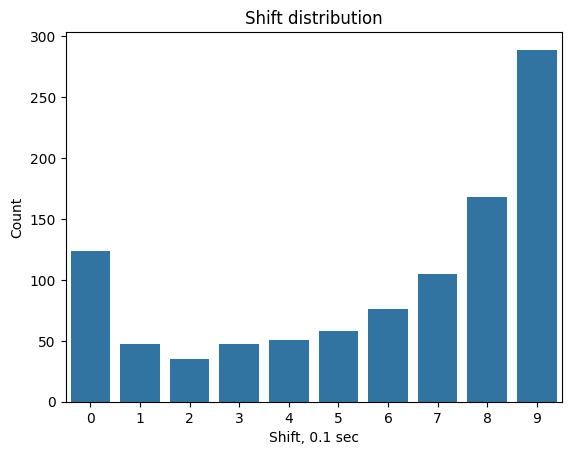

In [50]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr))))
plt.xlabel("Shift, 0.1 sec")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()

In [52]:
del cov_ts, imu_ts

In [68]:
%%time
def imu_stats(arr):
    # arr: (N, C, T) → output shape (N, (C+1)*4)
    acceleration = np.sqrt(np.sum(np.square(arr[:, -3:, :]), axis=1, keepdims=True))
    arr_stacked = np.concatenate((arr, acceleration), axis=1)
    mean = arr_stacked.mean(axis=2)
    std = arr_stacked.std(axis=2)
    mx = arr_stacked.max(axis=2)
    mn = arr_stacked.min(axis=2)
    return np.concatenate([mean, std, mx, mn], axis=1)
    
window_size = 0.3   # seconds  
step_size   = 0.1   # seconds  
sfreq       = 250   # Hz
SUBSAMPLE_SIZE = 1000

np.random.rand(SEED)
rand_indices = np.random.choice(len(y_total), SUBSAMPLE_SIZE, replace=False)
eeg = eeg_total[rand_indices]
imu = imu_total[rand_indices]

win_len = int(window_size * sfreq)  # → 75 samples  
step    = int(step_size   * sfreq)  # → 25 samples  
starts  = np.arange(0, eeg.shape[2] - win_len + 1, step)
n_win   = len(starts)

# pre‐allocate  
#   cov_ts:   (n_events, n_windows, n_chans, n_chans)  
#   imu_ts:   (n_events, n_windows, (n_imu+1)*4)  
cov_ts     = np.zeros((eeg.shape[0], n_win, eeg.shape[1]*(eeg.shape[1]+1)//2), dtype=np.float32)  
imu_ts     = np.zeros((imu.shape[0], n_win, (imu.shape[1]+1)*4),         dtype=np.float32)

pipe = Pipeline([('cov', Covariances(estimator='oas')), ('tangent', TangentSpace())])
setattr(pipe['tangent'], "reference_", Covariances('oas').transform(eeg_total[0:1])[0])

for w, start in tqdm(enumerate(starts), total=len(starts)):
    stop = start + win_len

    # --- EEG covariance for this window ---  
    seg_eeg = eeg[:, :, start:stop]           # (N_events, K_eeg, win_len)  
    cov_ts[:, w, :] = pipe.transform(seg_eeg)

    # --- IMU stats for this window ---  
    seg_imu = imu[:, :, start:stop]           # (N_events, K_imu, win_len)  
    imu_ts[:, w, :] = imu_stats(seg_imu)      # (mean, std, max, min for each ch + accel)  


  0%|          | 0/18 [00:00<?, ?it/s]

CPU times: user 9h 17min 53s, sys: 14h 57min 9s, total: 1d 15min 3s
Wall time: 1h 30min 17s


In [69]:
%%time
lag_set = np.arange(10)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr_2 = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(cov_ts.reshape(len(cov_ts), n_win, -1), imu_ts)
            ),
            total=len(cov_ts)
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.18 s, sys: 8.16 s, total: 9.34 s
Wall time: 5min 39s


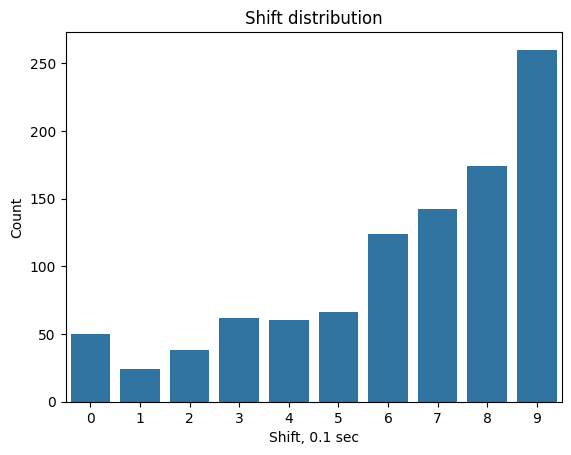

In [70]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr_2))))
plt.xlabel("Shift, 0.1 sec")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()

In [71]:
del cov_ts, imu_ts

In [77]:
eeg_tr = np.swapaxes(eeg, 1, 2)
imu_tr = np.swapaxes(imu, 1, 2)

In [78]:
lag_set = np.arange(0, 301, 25)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr_3 = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(eeg_tr, imu_tr)
            ),
            total=len(eeg_tr)
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

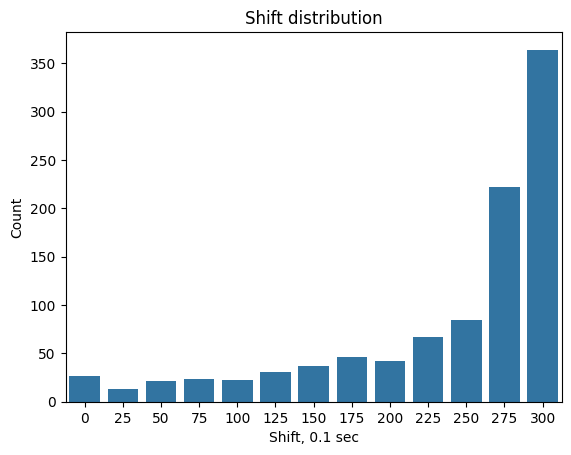

In [79]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr_3))))
plt.xlabel("Shift, 0.1 sec")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()